In [35]:
import numpy as np
import torch as th
import torch as th
import pandas as pd
import os, glob, sys, tqdm
from collections import defaultdict
from PIL import Image

def sh_to_ld(sh):
    #NOTE: Roughly Convert the SH to light direction
    sh = sh.reshape(-1, 9, 3)
    ld = th.mean(sh[0:1, 1:4, :], dim=2)
    return ld

def render_shadow_mask(sh_light, cam, verts, deca):
    sys.path.insert(0, '/home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/')
    from decalib.utils import util
    
    shadow_mask_all = []
    if verts.shape[0] >= 2:
        tmp = []
        for i in range(1, verts.shape[0]):
            tmp.append(th.allclose(verts[[0]], verts[[i]]))
        assert all(tmp)
        
    depth_image, alpha_image = deca.render.render_depth(verts.cuda())   # Depth : B x 1 x H x W
    _, _, h, w = depth_image.shape
    depth_grid = np.meshgrid(np.arange(h), np.arange(w), indexing='xy')
    depth_grid = np.repeat(np.stack((depth_grid), axis=-1)[None, ...], repeats=sh_light.shape[0], axis=0)   # B x H x W x 2
    depth_grid = np.concatenate((depth_grid, depth_image.permute(0, 2, 3, 1)[..., 0:1].cpu().numpy()), axis=-1) # B x H x W x 3
    depth_grid[..., 2] *= 256
    depth_grid = th.tensor(depth_grid).cuda()
    shadow_mask = th.clone(depth_grid[:, :, :, 2])
    # print(shadow_mask.shape, sh_light.shape)
    for i in range(sh_light.shape[0]):
        each_depth_grid = depth_grid[i].clone()
        #NOTE: Render the shadow mask from light direction
        ld = sh_to_ld(sh=th.tensor(sh_light[[i]])).cuda()
        ld = util.batch_orth_proj(ld[None, ...], cam[None, ...].cuda()); ld[:,:,1:] = -ld[:,:,1:]    # This fn takes pts=Bx3, cam=Bx3
        ray = ld.view(3).cuda()
        ray[2] *= 0.5
        n = 256
        ray = ray / th.norm(ray)
        mxaxis = max(abs(ray[0]), abs(ray[1]))
        shift = ray / mxaxis * th.arange(n).view(n, 1).cuda()
        coords = each_depth_grid.view(1, n, n, 3) + shift.view(n, 1, 1, 3)

        output = th.nn.functional.grid_sample(
            th.tensor(np.tile(each_depth_grid[:, :, 2].view(1, 1, n, n).cpu().numpy(), [n, 1, 1, 1])).cuda(),
            coords[..., :2] / (n - 1) * 2 - 1,
            align_corners=True)
        diff = coords[..., 2] - output[:, 0] 
        shadow_mask[i] *= (th.min(diff, dim=0)[0] > -0.1) * 0.5 + 0.5
        
    return th.clip(shadow_mask, 0, 255.0)/255.0

In [36]:
def read_params(path):
    params = pd.read_csv(path, header=None, sep=" ", index_col=False, lineterminator='\n')
    params.rename(columns={0:'img_name'}, inplace=True)
    params = params.set_index('img_name').T.to_dict('list')
    return params

def swap_key(params):
    params_s = defaultdict(dict)
    for params_name, v in params.items():
        for img_name, params_value in v.items():
            params_s[img_name][params_name] = np.array(params_value).astype(np.float64)

    return params_s

def load_deca_params(deca_dir, cfg):
    deca_params = {}

    # face params 
    params_key = ['cam', 'light', 'shape', 'pose', 'exp', 'tex', 'detail' ,'tform', 'albedo']
    for k in tqdm.tqdm(params_key, desc="Loading deca params..."):
        params_path = glob.glob(f"{deca_dir}/*{k}-anno.txt")
        for path in params_path:
            deca_params[k] = read_params(path=path)
    
    deca_params = swap_key(deca_params)
    return deca_params

def load_flame_mask(parts=['face']):
    f_mask = np.load('/home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/data/FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
    v_mask = np.load('/home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/data/FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
    mask={
        'v_mask':sum([v_mask[part].tolist() for part in parts], []),
        'f_mask':sum([f_mask[part].tolist() for part in parts], [])
    }

def init_deca(useTex=False, extractTex=True, device='cuda', 
              deca_mode='only_renderer', mask=None, deca_obj=None):
    
    # sys.path.insert(1, '/home/mint/guided-diffusion/preprocess_scripts/Relighting_preprocessing_tools/DECA/')
    sys.path.insert(1, '/home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/')
    # sys.path.insert(1, '/home/mint/Dev/DiFaReli/difareli-faster/sample_scripts/cond_utils/DECA/')

    from decalib import deca
    from decalib.utils.config import cfg as deca_cfg
    deca_cfg.model.use_tex = useTex
    deca_cfg.rasterizer_type = 'standard'
    deca_cfg.model.extract_tex = extractTex
    deca_obj = deca.DECA(config = deca_cfg, device=device, mode=deca_mode, mask=mask)
    return deca_obj


In [37]:
pth = '/data/mint/DPM_Dataset/ffhq_256_with_anno/params/'
set_ = 'valid'
params = load_deca_params(deca_dir=f'{pth}/{set_}/', cfg=None)
mask = load_flame_mask()
deca_obj = init_deca(mask=mask)

Loading deca params...: 100%|██████████| 9/9 [00:04<00:00,  2.19it/s]


creating the FLAME Decoder


In [46]:
sys.path.append('/home/mint/Dev/DiFaReli/difareli-faster/sample_scripts/sample_utils/')
import params_utils


img_name = '60065.jpg'
src_idx = 0
cond = {}
for k in params[img_name].keys():
    cond[k] = params[img_name][k][None, ]

for k in cond.keys():
    cond[k] = th.tensor(cond[k]).cuda()
    print(k, cond[k].shape)

cond['raw_image_path'] = [f'/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/{img_name}']
cond['raw_image'] = th.tensor(np.array(Image.open(cond['raw_image_path'][0]))).cuda().permute(2, 0, 1).float().unsqueeze(0)/255.0
deca_rendered, orig_visdict = params_utils.render_deca(deca_params=cond, 
                                                    idx=src_idx, n=1, 
                                                    avg_dict=None, 
                                                    render_mode='shape', 
                                                    rotate_normals=False, 
                                                    mask=mask,
                                                    deca_obj=deca_obj,
                                                    repeat=True)

print(deca_rendered.shape)
plt.imshow(deca_rendered[0].cpu().numpy().transpose(1, 2, 0))
plt.show()

shadow_mask = render_shadow_mask(
                sh_light=cond['light'], 
                cam=cond['cam'][src_idx],
                verts=orig_visdict['trans_verts_orig'], 
                deca=deca_obj)

cam torch.Size([1, 3])
light torch.Size([1, 27])
shape torch.Size([1, 100])
pose torch.Size([1, 6])
exp torch.Size([1, 50])
detail torch.Size([1, 128])
tform torch.Size([1, 9])
albedo torch.Size([1, 50])
1 1


/home/mint/Dev/DiFaReli/difareli-faster/sample_scripts/sample_utils/params_utils.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'light':th.tensor(deca_params['light']).to(device).reshape(-1, 9, 3).float(),


[#] There's 1 faces detected, using face 0
[#] There's 1 faces detected, using face 0
torch.Size([1, 3, 256, 256])


IndexError: too many indices for tensor of dimension 4

[0.]


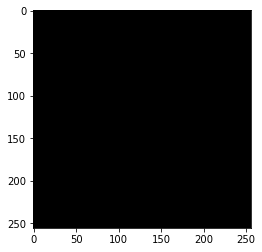

In [45]:
import matplotlib.pyplot as plt
print(np.unique(shadow_mask.cpu().numpy()))
plt.imshow(shadow_mask[0].cpu().numpy(), cmap='gray')
plt.show()